<a href="https://colab.research.google.com/github/aboltCD/aboltCD/blob/main/Lab_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

# Clasificación de Imágenes

Este tutorial muestra cómo clasificar imágenes de flores. Crearemos un clasificador de imágenes usando un modelo tf.keras.Sequential y cargaremos los datos usando tf.keras.utils.image_dataset_from_directory . En este Laboratorio adquirirás experiencia práctica con los siguientes conceptos:


*   Carga eficiente de un conjunto de datos fuera del disco.
*   Identificar el sobreajuste y aplicar técnicas para mitigarlo, incluido el aumento y la eliminación de datos.

Este tutorial sigue un flujo de trabajo básico de aprendizaje automático:

1.   Examinar y comprender los datos.
2.   Crear una canalización de entrada
3.   Construye el modelo
4.   Entrenar al modelo
5.   Probar el modelo
6.   Mejorar el modelo y repetir el proceso








## Importar TensorFlow y otras bibliotecas



In [64]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Descargar y explorar el conjunto de datos

Este tutorial utiliza un conjunto de datos de unas 3700 fotos de flores. El conjunto de datos contiene cinco subdirectorios, uno por clase:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [65]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

Después de la descarga, ahora debería tener una copia del conjunto de datos disponible. Hay 3.670 imágenes en total:

In [66]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Veamos algunas rosas:

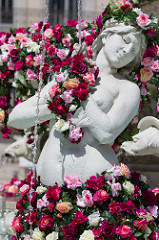

In [67]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

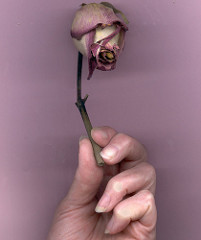

In [68]:
PIL.Image.open(str(roses[1]))

Y algunas Margaritas:

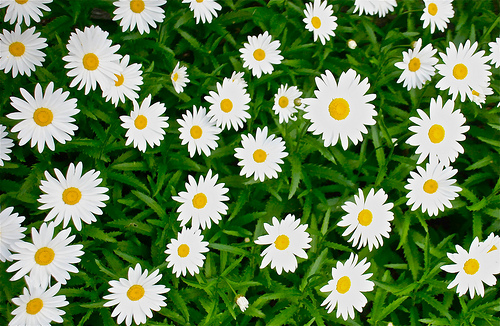

In [69]:
daisy = list(data_dir.glob('daisy/*'))
PIL.Image.open(str(daisy[0]))

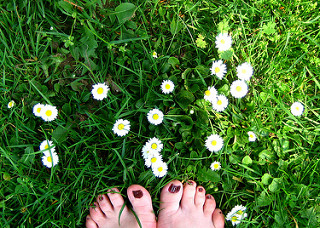

In [70]:
PIL.Image.open(str(daisy[1]))

# Cargue datos usando Keras

Carguemos estas imágenes fuera del disco utilizando la útil utilidad `tf.keras.utils.image_dataset_from_directory` . Esto lo llevará de un directorio de imágenes en el disco a un `tf.data.Dataset` en solo un par de líneas de código.

## Creando el Dataset

Definimos algunos parámetros para el cargador:



In [71]:
batch_size = 32
img_height = 180
img_width = 180

Es una buena práctica usar una división de validación al desarrollar su modelo. Usemos el 80% de las imágenes para entrenamiento y el 20% para validación

In [72]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [73]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Puede encontrar los nombres de clase en el atributo `class_names` en estos conjuntos de datos. Estos corresponden a los nombres de los directorios en orden alfabético.

In [74]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualizar los Datos

Estas son las primeras 4 imágenes del set de datos de entrenamiento:

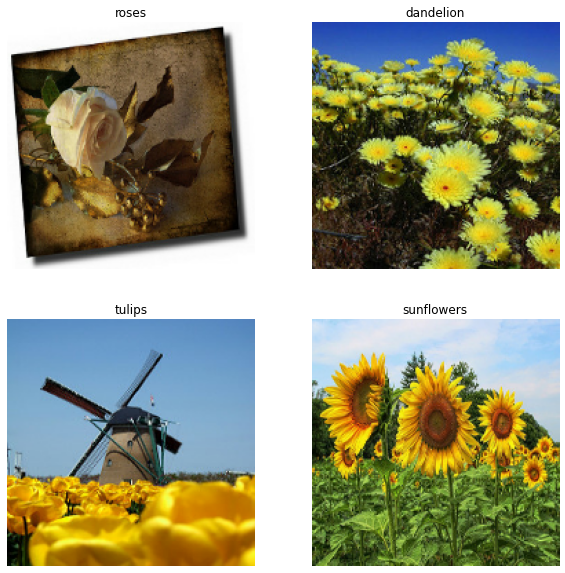

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Ahora entrenaremos un modelo usando estos conjuntos de datos pasándolos a `Model.fit` en un momento. Si lo desea, también puede iterar manualmente sobre el conjunto de datos y recuperar lotes de imágenes:

In [76]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch` es un tensor de la forma `(32, 180, 180, 3)` . Este es un lote de 32 imágenes de forma `180x180x3` (la última dimensión se refiere a los canales de color RGB). El `label_batch` es un tensor de la forma `(32,)` , estas son las etiquetas correspondientes a las 32 imágenes.

Puede llamar a `.numpy()` en los tensores `image_batch` y `labels_batch` para convertirlos en `numpy.ndarray`

## Configurar (optimizar) el conjunto de datos para el rendimiento

Asegurémonos de utilizar la captación previa almacenada en búfer para que pueda obtener datos del disco sin que la E/S se convierta en un cuello de botella. Estos son dos métodos importantes que debe usar al cargar datos:

 

*   `Dataset.cache` mantiene las imágenes en la memoria después de que se cargan fuera del disco durante la primera época. Esto asegurará que el conjunto de datos no se convierta en un cuello de botella mientras entrena su modelo. Si su conjunto de datos es demasiado grande para caber en memoria, también puede usar este método para crear un caché en disco.
*   `Dataset.prefetch` superpone el preprocesamiento de datos y la ejecución del modelo durante el entrenamiento.

Para más información sobre ambos métodos, así como información sobre cómo almacenar datos en caché en el disco, en la sección `Precarga` de la guía `Mejor rendimiento con la API tf.data` .[Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [77]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Estandarizar los Datos

Los valores del canal RGB están en el rango `[0, 255]` . Esto no es ideal para una red neuronal; en general, debe buscar que sus valores de entrada sean pequeños.

Aquí, estandarizará los valores para que estén en el rango `[0, 1]` usando `tf.keras.layers.Rescaling`:

In [78]:
normalization_layer = layers.Rescaling(1./255)

Hay dos formas de usar esta estandarización: La primera opción es aplicarlo al conjunto de datos completo directamente, llamando a `Dataset.map`:

In [79]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


O bien, puede incluir la estandarización como una capa dentro de la definición de su modelo, lo que puede simplificar la implementación. Usemos el segundo enfoque aquí.

Nota: anteriormente cambiaste el tamaño de las imágenes usando el argumento `image_size` de `tf.keras.utils.image_dataset_from_directory`. Si también deseas incluir la lógica de cambio de tamaño en su modelo, puedes usar la capa `tf.keras.layers.Resizing`.

# Crear el Modelo

El modelo [secuencial](https://www.tensorflow.org/guide/keras/sequential_model) consta de tres bloques de convolución (`tf.keras.layers.Conv2D`) con una capa de *max pooling* (`tf.keras.layers.MaxPooling2D`) en cada uno de ellos. Hay una capa densa o totalmente conectada (`tf.keras.layers.Dense`) con 128 unidades encima que se activa mediante una función de activación de ReLU (`'relu'`). Este modelo no se ha ajustado para una alta precisión; el objetivo de este tutorial es mostrar un enfoque estándar.

In [80]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilar el Modelo

Para este tutorial, elija el optimizador `tf.keras.optimizers.SGD` y la función de pérdida `tf.keras.losses.SparseCategoricalCrossentropy`. Para una guía completa sobre funciones de pérdida en Keras, visite el siguiente [enlace](https://neptune.ai/blog/keras-loss-functions). 
Para ver la precisión del entrenamiento y la validación para cada época de entrenamiento, pase el argumento de metrics a `Model.compile`.

In [81]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Resumen del Modelo **(Importante!)**

Vea la estructura y todas las capas de la red utilizando el método `Model.summary` del modelo:

In [82]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 64)       

## Entrenando el Modelo

In [83]:
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 3s 34ms/step - loss: 1.5081 - accuracy: 0.3283 - val_loss: 1.3800 - val_accuracy: 0.4005
Epoch 2/20
92/92 [==============================] - 2s 23ms/step - loss: 1.2838 - accuracy: 0.4523 - val_loss: 1.2734 - val_accuracy: 0.4768
Epoch 3/20
92/92 [==============================] - 2s 23ms/step - loss: 1.1501 - accuracy: 0.5191 - val_loss: 1.1012 - val_accuracy: 0.5259
Epoch 4/20
92/92 [==============================] - 2s 23ms/step - loss: 1.0818 - accuracy: 0.5630 - val_loss: 1.1054 - val_accuracy: 0.5477
Epoch 5/20
92/92 [==============================] - 2s 23ms/step - loss: 1.0434 - accuracy: 0.5828 - val_loss: 1.0458 - val_accuracy: 0.5954
Epoch 6/20
92/92 [==============================] - 2s 23ms/step - loss: 0.9936 - accuracy: 0.6158 - val_loss: 1.0443 - val_accuracy: 0.5913
Epoch 7/20
92/92 [==============================] - 2s 24ms/step - loss: 0.9657 - accuracy: 0.6277 - val_loss: 1.0571 - val_accuracy: 0.5804
Epoch 8/20
92

## Visualizar resultados del Entrenamiento

Creamos gráficos de pérdida y de la precisión (*accuracy*) en los conjuntos de entrenamiento y validación:

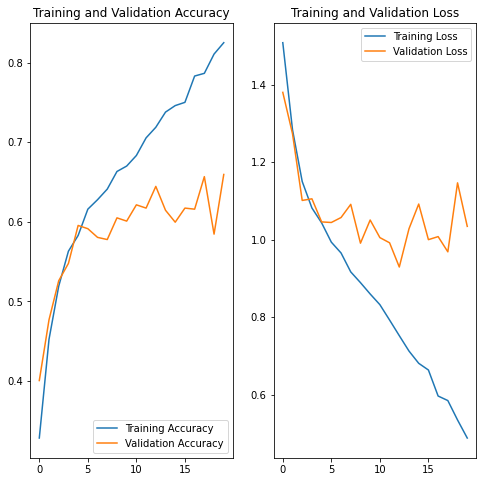

In [84]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Los gráficos muestran que la precisión del entrenamiento y la precisión de la validación están desviadas por amplios márgenes, y el modelo ha logrado solo alrededor del 60 % de precisión en el conjunto de validación.

Inspeccionemos qué salió mal e intentemos aumentar el rendimiento general del modelo.

## Sobreajuste / *Overfitting*

En los gráficos anteriores, la precisión del entrenamiento aumenta linealmente con el tiempo, mientras que la precisión de la validación se detiene alrededor del 60 % en el proceso de entrenamiento. Además, la diferencia en la precisión entre la precisión del entrenamiento y la validación es notable, un signo de [sobreajuste o *overfitting*](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Cuando hay una pequeña cantidad de ejemplos de entrenamiento, el modelo a veces aprende de los ruidos o detalles no deseados de los ejemplos de entrenamiento, hasta el punto de afectar negativamente el rendimiento del modelo en los nuevos ejemplos. Este fenómeno se conoce como sobreajuste. Significa que el modelo tendrá dificultades para generalizar en un nuevo conjunto de datos.

Hay múltiples formas de combatir el sobreajuste en el proceso de entrenamiento. En este tutorial, utilizará el aumento de datos y agregará `Dropout` a su modelo.


## Aumento de los Datos

El sobreajuste generalmente ocurre cuando hay una pequeña cantidad de ejemplos de entrenamiento. El aumento de datos adopta el enfoque de generar datos de entrenamiento adicionales a partir de sus ejemplos existentes al "aumentarlos" mediante transformaciones aleatorias que producen imágenes de aspecto creíble. Esto ayuda a exponer el modelo a más aspectos de los datos y a generalizar mejor.

Implementaremos el aumento de datos utilizando las siguientes capas de preprocesamiento de Keras: `tf.keras.layers.RandomFlip` , `tf.keras.layers.RandomRotation` y `tf.keras.layers.RandomZoom`. Estos pueden incluirse dentro de su modelo como otras capas y ejecutarse en la GPU.

In [85]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualicemos cómo se ven algunos ejemplos aumentados aplicando el aumento de datos a la misma imagen varias veces:

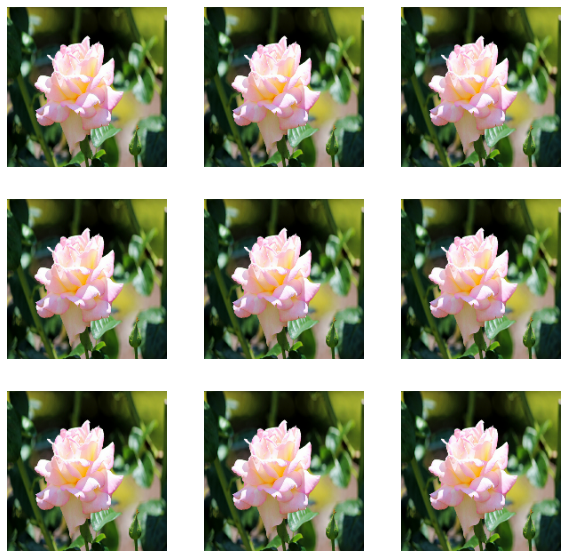

In [86]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Utilizaremos el aumento de datos para entrenar un modelo más adelante.

## Abandono / *Dropout*

Otra técnica para reducir el sobreajuste es introducir la regularización de abandono o [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) a la red.

Cuando aplica abandono a una capa, descarta aleatoriamente (estableciendo la activación en cero) una cantidad de unidades de salida de la capa durante el proceso de entrenamiento. Dropout toma un número fraccionario como su valor de entrada, en forma de 0.1, 0.2, 0.4, etc. Esto significa eliminar aleatoriamente el 10%, 20% o 40% de las unidades de salida de la capa aplicada.

Vamos a crear una nueva red neuronal con una capa `tf.keras.layers.Dropout` antes de entrenarla usando las imágenes aumentadas:

In [87]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compilar y Entrenar el Modelo

In [88]:
model.compile(optimizer='SGD',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [89]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [90]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
92/92 [==============================] - 3s 27ms/step - loss: 1.5552 - accuracy: 0.3018 - val_loss: 1.4583 - val_accuracy: 0.3774
Epoch 2/20
92/92 [==============================] - 2s 26ms/step - loss: 1.4159 - accuracy: 0.3757 - val_loss: 1.3166 - val_accuracy: 0.4373
Epoch 3/20
92/92 [==============================] - 2s 26ms/step - loss: 1.2681 - accuracy: 0.4496 - val_loss: 1.1463 - val_accuracy: 0.5409
Epoch 4/20
92/92 [==============================] - 2s 26ms/step - loss: 1.1584 - accuracy: 0.5146 - val_loss: 1.1272 - val_accuracy: 0.5272
Epoch 5/20
92/92 [==============================] - 2s 26ms/step - loss: 1.1108 - accuracy: 0.5467 - val_loss: 1.0675 - val_accuracy: 0.5777
Epoch 6/20
92/92 [==============================] - 2s 26ms/step - loss: 1.0818 - accuracy: 0.5671 - val_loss: 1.0767 - val_accuracy: 0.5763
Epoch 7/20
92/92 [==============================] - 2s 26ms/step - loss: 1.0581 - accuracy: 0.5862 - val_loss: 1.0678 - val_accuracy: 0.5627
Epoch 8/20
92

## Visualizando los resultados del Entrenamiento

Después de aplicar el aumento de datos y `tf.keras.layers.Dropout`, hay menos sobreajuste que antes, y la precisión del entrenamiento y la validación están más alineadas:

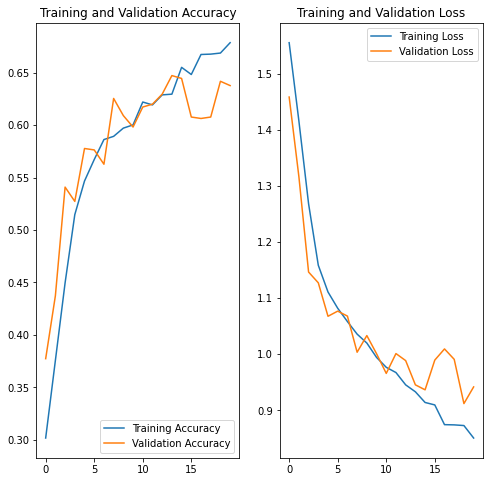

In [91]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predicciones con datos (imágenes) nuevos

Finalmente, usaremos nuestro modelo para clasificar una imagen que no se incluyó en los conjuntos de entrenamiento o validación

Nota: las capas de aumento de datos y abandono de datos (dropout) están **inactivas** en el momento de la predicción.


Primero, visualizamos la nueva imágen que vamos a pasar por la red para obtener una predicción:

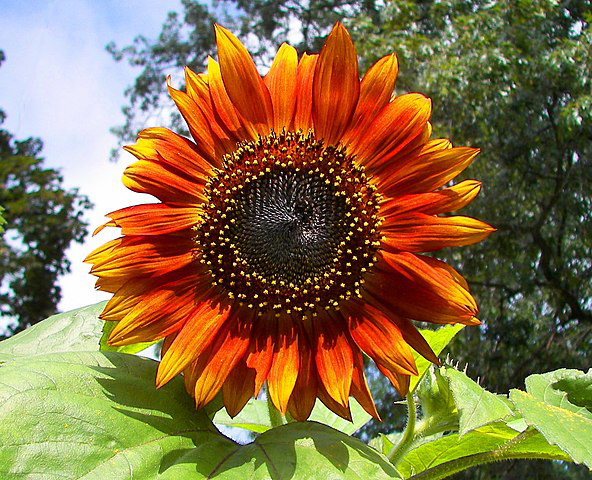

In [92]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

PIL.Image.open(str(sunflower_path))



Ahora, cargamos la imágen en un arreglo, lo pasamos a la función `Model.predict` e imprimimos los resultados:

In [93]:
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch



predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to tulips with a 51.27 percent confidence.
